## Detectron 2


[Detectron2](https://github.com/facebookresearch/detectron2) is a framework for building state-of-the-art object detection and image segmentation models. It is developed by the Facebook Research team. Detectron2 is a complete rewrite of the [first version](https://github.com/facebookresearch/Detectron).

Under the hood, Detectron2 uses PyTorch (compatible with the latest version(s)) and allows for [blazing fast training](https://detectron2.readthedocs.io/notes/benchmarks.html).

### Installing Detectron2

At the time of this writing, Detectron2 is still in an alpha stage. While there is an official release, we'll clone and compile from the master branch. This should equal version 0.1.

In [ ]:
!pip install -q cython pyyaml==5.1
!pip install -q -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

     |████████████████████████████████| 274 kB 5.5 MB/s 


And download, compile, and install the Detectron2 package:

In [ ]:
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -q -e detectron2_repo

Cloning into 'detectron2_repo'...
remote: Enumerating objects: 13686, done.
remote: Counting objects: 100% (1187/1187), done.
remote: Compressing objects: 100% (565/565), done.
remote: Total 13686 (delta 767), reused 884 (delta 613), pack-reused 12499
Receiving objects: 100% (13686/13686), 5.81 MiB | 15.82 MiB/s, done.
Resolving deltas: 100% (9715/9715), done.
     |████████████████████████████████| 106 kB 5.5 MB/s 
     |████████████████████████████████| 49 kB 5.5 MB/s 
     |████████████████████████████████| 74 kB 3.0 MB/s 
     |████████████████████████████████| 145 kB 38.8 MB/s 
     |████████████████████████████████| 130 kB 32.9 MB/s 
     |████████████████████████████████| 749 kB 39.9 MB/s 
     |████████████████████████████████| 843 kB 32.1 MB/s 
     |████████████████████████████████| 112 kB 45.2 MB/s 


> At this point, you'll need to restart the notebook runtime to continue!

In [ ]:
!pip install -q -U watermark

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
markdown 3.3.6 requires importlib-metadata>=4.4; python_version < "3.10", but you have importlib-metadata 2.1.2 which is incompatible.


In [ ]:
%reload_ext watermark
%watermark -v -p numpy,pandas,pycocotools,torch,torchvision,detectron2

Python implementation: CPython
Python version       : 3.7.12
IPython version      : 5.5.0

numpy      : 1.19.5
pandas     : 1.1.5
pycocotools: 2.0.3
torch      : 1.10.0+cu111
torchvision: 0.11.1+cu111
detectron2 : 0.6



In [ ]:
!pip install mmcv

     |████████████████████████████████| 403 kB 5.4 MB/s 
     |████████████████████████████████| 185 kB 38.9 MB/s 
  Created wheel for mmcv: filename=mmcv-1.4.0-py2.py3-none-any.whl size=596725 sha256=e67a34912d68d6d5ed5bd3bfa03f620485b6014765b4405b6c1fb121be02914c
  Stored in directory: /root/.cache/pip/wheels/6e/b8/45/6b876315baf46f8b961262be222f42bcf71cc1d1b7a05d6136
Successfully built mmcv


In [ ]:
import torch, torchvision
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import glob

import os
import ntpath
import numpy as np
import cv2
import random
import itertools
import pandas as pd
from tqdm import tqdm
import urllib
import json
import PIL.Image as Image

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.structures import BoxMode
from detectron2.engine import DefaultTrainer
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

import sys
import torch
import mmcv
import itertools
from detectron2.structures import BoxMode

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [ ]:
from google.colab import drive

drive._mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
os.chdir('./gdrive/MyDrive/DL_visualization/VRDL_HW3')

In [ ]:
classes = ["nucleus"]

In [ ]:
from pycocotools import mask
from skimage import measure

In [ ]:
data_path = os.listdir('./train/')

train_data = data_path[:22]
val_data = data_path[22:]
def get_dicts(data):
  images = []
  dataset_dicts = []
  for idx in range(len(data)):
      # load images ad masks
      path = data[idx]
      img = Image.open('./train/' + path + '/images/' + path + '.png').convert("RGB")
      img = np.array(img)

      mask_path = os.listdir('./train/' + path + '/masks/')
      num_objs = len(mask_path)

      shape = img.shape
      height = shape[0]
      width = shape[1]
      filename = './data/train_jpg/' + path + '.jpg'
      obj_count = 0
      annotations = []
      record = {}
      for i in mask_path:
          if i ==".ipynb_checkpoints":
              continue
          boxes = []
          bbox = []
          masks = cv2.imread('./train/' + path + '/masks/' + i)
          ground_truth_binary_mask = masks[:,:,0]
          fortran_ground_truth_binary_mask = np.asfortranarray(ground_truth_binary_mask)
          encoded_ground_truth = mask.encode(fortran_ground_truth_binary_mask)
          ground_truth_area = mask.area(encoded_ground_truth)
          ground_truth_bounding_box = mask.toBbox(encoded_ground_truth)
          contours = measure.find_contours(ground_truth_binary_mask, 0.5)
          for contour in contours:
            contour = np.flip(contour, axis=1)
            segmentation = contour.ravel().tolist()
    
          masks = np.array(masks)
          obj_ids = np.unique(masks)
          obj_ids = obj_ids[1:]
      # split the color-encoded mask into a set of binary masks
          masks == obj_ids[:, None, None]
      # get bounding box coordinates for each mask
      # there is only one class
          category = 0
      # suppose all instances are not crowd
          iscrowd = 0
          target = {"category_id" : category, #
          "bbox":ground_truth_bounding_box, #
          "bbox_mode":category + 1,
          # "id":obj_count, #
          # "area":area.item(), #
          "iscrowd":iscrowd, #
          "segmentation":[]}
          target["segmentation"].append(segmentation)
          
          annotations.append(target)
          obj_count += 1
      record["file_name"] = filename
      record["height"] = 1000
      record["width"] = 1000
      record["image_id"] = idx
      record["annotations"] = annotations
      dataset_dicts.append(record)
  return dataset_dicts

In [ ]:
# train_df = get_dicts(train_data)
# mmcv.dump(train_df, './train.json')
# val_df = get_dicts(val_data)
# mmcv.dump(val_df, './val.json')
# df = get_dicts(data_path)
# mmcv.dump(df, './data.json')

In [ ]:
with open('./train.json', newline='') as jsonfile:
  train_df = json.load(jsonfile)
with open('./val.json', newline='') as jsonfile_test:
  val_df = json.load(jsonfile_test)
with open('./data.json', newline='') as jsonfile_test:
  df = json.load(jsonfile_test)

In [ ]:
print(len(train_df))
print(len(val_df))
print(len(df))

22
2
24


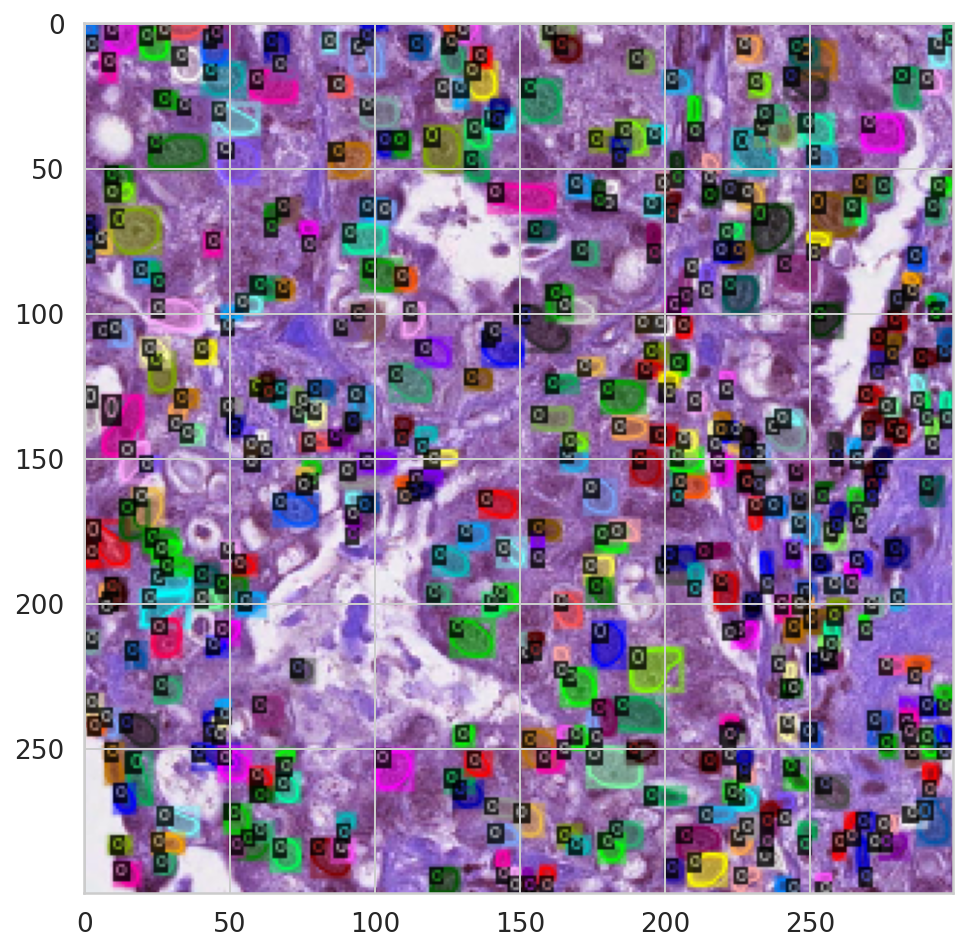

In [ ]:
# dataset_dicts = DatasetCatalog.get("my_dataset_train")
for d in random.sample(val_df, 1):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], scale=0.3)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::-1])

In [ ]:
for d in ["train", "val"]:
  DatasetCatalog.register("nucleus_" + d, lambda d=d: df if d == "train" else val_df)
  MetadataCatalog.get("nucleus_" + d).set(thing_classes=classes)

statement_metadata = MetadataCatalog.get("nucleus_train")

In [ ]:
class CocoTrainer(DefaultTrainer):
  
  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

The evaluation results will be stored in the `coco_eval` folder if no folder is provided.

use the Mask R-CNN X101-FPN model

In [ ]:
cfg = get_cfg()
#mask_rcnn_R_50_FPN_3x.yaml
#mask_rcnn_R_50_FPN_1x.yaml
# mask_rcnn_X_101_32x8d_FPN_3x.yaml
cfg.merge_from_file(
  model_zoo.get_config_file(
    "COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"
  )
)

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
  "COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"
)

'https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x/139653917/model_final_2d9806.pkl'

Specify the datasets

In [ ]:
cfg.DATASETS.TRAIN = ("nucleus_train",)
cfg.DATASETS.TEST = ("nucleus_val",)
cfg.DATALOADER.NUM_WORKERS = 4

In [ ]:
cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.STEPS = (1000, 1500)
cfg.SOLVER.GAMMA = 0.05

In [ ]:
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 32
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(classes)
cfg.TEST.EVAL_PERIOD = 100

In [ ]:
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0025  # pick a good LR
cfg.SOLVER.MAX_ITER = 2500   
cfg.SOLVER.STEPS = []        # do not decay learning rate

In [ ]:
cfg.OUTPUT_DIR = './output_test'
cfg.MODEL.ANCHOR_GENERATOR.SIZES = [[8], [16], [32], [64], [128]]

In [ ]:
print(cfg)

CUDNN_BENCHMARK: False
DATALOADER:
  ASPECT_RATIO_GROUPING: True
  FILTER_EMPTY_ANNOTATIONS: True
  NUM_WORKERS: 4
  REPEAT_THRESHOLD: 0.0
  SAMPLER_TRAIN: TrainingSampler
DATASETS:
  PRECOMPUTED_PROPOSAL_TOPK_TEST: 1000
  PRECOMPUTED_PROPOSAL_TOPK_TRAIN: 2000
  PROPOSAL_FILES_TEST: ()
  PROPOSAL_FILES_TRAIN: ()
  TEST: ('nucleus_val',)
  TRAIN: ('nucleus_train',)
GLOBAL:
  HACK: 1.0
INPUT:
  CROP:
    ENABLED: False
    SIZE: [0.9, 0.9]
    TYPE: relative_range
  FORMAT: BGR
  MASK_FORMAT: polygon
  MAX_SIZE_TEST: 1333
  MAX_SIZE_TRAIN: 1333
  MIN_SIZE_TEST: 800
  MIN_SIZE_TRAIN: (640, 672, 704, 736, 768, 800)
  MIN_SIZE_TRAIN_SAMPLING: choice
  RANDOM_FLIP: horizontal
MODEL:
  ANCHOR_GENERATOR:
    ANGLES: [[-90, 0, 90]]
    ASPECT_RATIOS: [[0.5, 1.0, 2.0]]
    NAME: DefaultAnchorGenerator
    OFFSET: 0.0
    SIZES: [[8], [16], [32], [64], [128]]
  BACKBONE:
    FREEZE_AT: 2
    NAME: build_resnet_fpn_backbone
  DEVICE: cuda
  FPN:
    FUSE_TYPE: sum
    IN_FEATURES: ['res2', 'res3',

In [ ]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

trainer = CocoTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[12/11 10:08:00 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[12/11 10:08:02 d2.checkpoint.c2_model_loading]: Renaming Caffe2 weights ......
[12/11 10:08:02 d2.checkpoint.c2_model_loading]: Following weights matched with submodule backbone.bottom_up:
| Names in Model    | Names in Checkpoint                         | Shapes                                          |
|:------------------|:--------------------------------------------|:------------------------------------------------|
| res2.0.conv1.*    | res2_0_branch2a_{bn_b,bn_rm,bn_riv,bn_s,w}  | (256,) (256,) (256,) (256,) (256,64,1,1)        |
| res2.0.conv2.*    | res2_0_branch2b_{bn_b,bn_rm,bn_riv,bn_s,w}  | (256,) (256,) (256,) (256,) (256,8,3,3)         |
| res2.0.conv3.*    | res2_0_branch2c_{bn_b,bn_rm,bn_riv,bn_s,w}  | (256,) (256,) (256,) (256,) (256,256,1,1)       |
| res2.0.shortcut.* | res2_0_branch1_{bn_b,bn_rm,bn_riv,bn_s,w}   | (256,) (256,) (256,) (256,) (256,64,1,1)        |
| res2.1.conv1.*    | res2_1_branch2a_{bn_b,bn_rm,bn_riv,bn_s,w}  | (256,) (256,) (256,) (256,) (256,2

Some model parameters or buffers are not found in the checkpoint:
backbone.fpn_lateral2.{bias, weight}
backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output2.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.conv.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_head.fc1.{bias, weight}
roi_heads.box_head.fc2.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.deconv.{bias, weight}
roi_heads.mask_head.mask_fcn1.{bias, weight}
roi_heads.mask_head.mask_fcn2.{bias, weight}
roi_heads.mask_head.mask_fcn3.{bias, weight}
roi_heads.mask_head.mask_fcn4.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}
The checkpoint state_dict contains 

[12/11 10:08:02 d2.engine.train_loop]: Starting training from iteration 0
[12/11 10:08:22 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7fd3686d99e0> to CPU due to CUDA OOM
[12/11 10:09:29 d2.utils.events]:  eta: 1:50:25  iter: 19  total_loss: 2.394  loss_cls: 0.6183  loss_box_reg: 0.01822  loss_mask: 0.6894  loss_rpn_cls: 0.6903  loss_rpn_loc: 0.3637  time: 4.3326  data_time: 0.1858  lr: 4.9952e-05  max_mem: 10177M
[12/11 10:09:33 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7fd3686d99e0> to CPU due to CUDA OOM
[12/11 10:10:27 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7fd3686d99e0> to CPU due to CUDA OOM
[12/11 10:11:04 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7fd3686d99e0> to CPU due to CUDA OOM
[12/11 10:11:27 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7fd3686d99e0> to CPU due to CUDA OOM
[12/11 10:11:56 d2.utils.events]:  eta:

## Evaluating Object Detection Models

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "./model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6
predictor = DefaultPredictor(cfg)

In [ ]:
# IMAGES_PATH = f'./data/test_jpg'
evaluator = COCOEvaluator("nucleus_val", cfg, output_dir="./output_test/")
val_loader = build_detection_test_loader(cfg, "nucleus_val")
inference_on_dataset(predictor.model, val_loader, evaluator)

WARNING [12/10 17:17:11 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[12/10 17:17:12 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[12/10 17:17:12 d2.data.common]: Serializing 2 elements to byte tensors and concatenating them all ...
[12/10 17:17:12 d2.data.common]: Serialized dataset takes 1.38 MiB
[12/10 17:17:12 d2.evaluation.evaluator]: Start inference on 2 batches


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[12/10 17:17:15 d2.evaluation.evaluator]: Total inference time: 0:00:01.574958 (1.574958 s / iter per device, on 1 devices)
[12/10 17:17:15 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:01 (1.151435 s / iter per device, on 1 devices)
[12/10 17:17:15 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[12/10 17:17:15 d2.evaluation.coco_evaluation]: Saving results to ./output/coco_instances_results.json
[12/10 17:17:15 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
[12/10 17:17:15 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[12/10 17:17:15 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.03 seconds.
[12/10 17:17:15 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[12/10 17:17:15 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.00 seconds.
 Average Precision  (AP)

OrderedDict([('bbox',
              {'AP': 13.43556066226067,
               'AP50': 25.676780581283936,
               'AP75': 11.035796553183282,
               'APl': nan,
               'APm': 29.884730817211658,
               'APs': 11.924158382828894}),
             ('segm',
              {'AP': 12.676122967997646,
               'AP50': 25.46183328010221,
               'AP75': 11.554744409344035,
               'APl': nan,
               'APm': 33.51216269366194,
               'APs': 10.977342813339778})])